In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import labelme
import base64
import io
import cv2
import matplotlib
import matplotlib.pyplot as plt
import PIL
# Root directory of the project
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import json
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
print(MODEL_DIR, COCO_MODEL_PATH)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # 按照PCI_BUS_ID顺序从0开始排列GPU设备
os.environ["CUDA_VISIBLE_DEVICES"]= '0'  # 使用0号gpu（想使用其他编号GPU，对应修改引号中的内容即可）

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

import warnings 
warnings.filterwarnings('ignore')

[WARNING] deprecation:<module>:40 - Deprecation warnings have been disabled. Set TF_ENABLE_DEPRECATION_WARNINGS=1 to re-enable them.


Using TensorFlow backend.


1.15.4
['/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core/python/keras/api/_v1', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/api/_v1', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core', '/root/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow_core/_api/v1']
/home/wangjy/research/maskrcnn/logs /home/wangjy/research/maskrcnn/mask_rcnn_coco.h5


In [2]:

# train config
class FacesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "faces"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    BACKBONE = "resnet50"
    
    IMAGE_RESIZE_MODE = "crop"

config = FacesConfig()

config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:

# dataset
class FacesDataset(utils.Dataset):
    def __init__(self, dataset_type='train'):
        super(FacesDataset, self).__init__()

        self.DATA_ROOT_DIR = './facedata'

        # Add classes
        self.add_class("faces", 1, "opencomedo")
        self.add_class("faces", 2, "closedcomedo")
        self.add_class("faces", 3, "papule")
        self.add_class("faces", 4, "nudule")
        self.add_class("faces", 5, "scar")
        self.add_class("faces", 6, "undefined")

        all_label_path_list = os.listdir(self.DATA_ROOT_DIR)
        data_len = len(all_label_path_list)

        if dataset_type=='train':
            # label_path_list = all_label_path_list[:int(0.8*data_len)]
            label_path_list = all_label_path_list[:5]
        elif  dataset_type=='val':
            # label_path_list = all_label_path_list[int(0.8*data_len):]
            label_path_list = all_label_path_list[6:8]
        else:
            raise NotImplementedError

        # 将所有信息放到Image info 中
        for i, label_path in enumerate(label_path_list):
            self.add_image("faces", image_id=i, path=label_path)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        label_path = info['path']

        # 读取json文件
        with open(os.path.join(self.DATA_ROOT_DIR, label_path), encoding='utf-8') as json_file:
            labelmeJson = json.load(json_file)
            # height = labelmeJson['imageHeight']
            # width = labelmeJson['imageWidth']
            # shape_list = labelmeJson['shapes']
            image = self.img_b64_to_arr(labelmeJson['imageData'])
            # bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
            # image = np.ones([labelmeJson['height'], labelmeJson['width'], 3], dtype=np.uint8)
            # image = image * bg_color.astype(np.uint8)
            #
            # for shape, color, dims in info['shapes']:
            #     image = self.draw_shape(image, shape, dims, color)

            return image

    def img_b64_to_arr(self, img_b64):
        img_data = base64.b64decode(img_b64)
        f = io.BytesIO()
        f.write(img_data)
        img_pil = PIL.Image.open(f)
        img_arr = np.asarray(img_pil)
        return img_arr

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "faces":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def shape_to_mask(self, img_shape, points, shape_type=None, line_width=10, point_size=5):
        mask = np.zeros(img_shape[:2], dtype=np.uint8)
        mask = PIL.Image.fromarray(mask)
        draw = PIL.ImageDraw.Draw(mask)
        xy = [tuple(point) for point in points]
        if shape_type == "circle":
            assert len(xy) == 2, "Shape of shape_type=circle must have 2 points"
            (cx, cy), (px, py) = xy
            d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
            draw.ellipse([cx - d, cy - d, cx + d, cy + d], outline=1, fill=1)
        elif shape_type == "rectangle":
            assert len(xy) == 2, "Shape of shape_type=rectangle must have 2 points"
            draw.rectangle(xy, outline=1, fill=1)
        elif shape_type == "line":
            assert len(xy) == 2, "Shape of shape_type=line must have 2 points"
            draw.line(xy=xy, fill=1, width=line_width)
        elif shape_type == "linestrip":
            draw.line(xy=xy, fill=1, width=line_width)
        elif shape_type == "point":
            assert len(xy) == 1, "Shape of shape_type=point must have 1 points"
            cx, cy = xy[0]
            r = point_size
            draw.ellipse([cx - r, cy - r, cx + r, cy + r], outline=1, fill=1)
        else:
            assert len(xy) > 2, "Polygon must have points more than 2"
            draw.polygon(xy=xy, outline=1, fill=1)
        mask = np.array(mask, dtype=bool)
        return mask

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        label_path = info['path']

        # 读取json文件
        with open(os.path.join(self.DATA_ROOT_DIR, label_path), encoding='utf-8') as json_file:
            labelmeJson = json.load(json_file)
            height = labelmeJson['imageHeight']
            width = labelmeJson['imageWidth']
            shapes = labelmeJson['shapes']

            count = len(shapes)
            mask = np.zeros([height, width, count], dtype=np.uint8)

            for i, shape in enumerate(shapes):
                mask[:, :, i] = self.shape_to_mask(mask.shape, shape['points'], shape['shape_type'])

            # Map class names to class IDs.
            class_ids = np.array([self.class_names.index(shape['label']) if shape['label'] in self.class_names else self.class_names.index('undefined') for shape in shapes])
            #print('class_ids:', class_ids)
            #input()
            return mask.astype(np.bool), class_ids.astype(np.int32)


print('prepare finish')

# Training dataset
dataset_train = FacesDataset('train')
dataset_train.prepare()

# Validation dataset
dataset_val = FacesDataset('val')
dataset_val.prepare()

prepare finish


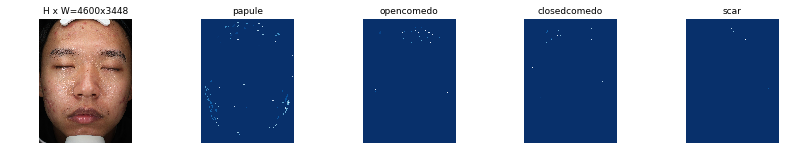

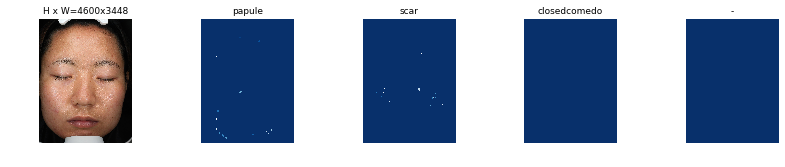

In [5]:

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [6]:

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
print('load dataset and model')

[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.




load dataset and model


In [7]:

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

print('init weights finished')

[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.




init weights finished


In [ ]:

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=500, layers='heads')

[INFO   ] utils:_init_num_threads:129 - Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO   ] utils:_init_num_threads:141 - NumExpr defaulting to 8 threads.



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/wangjy/research/maskrcnn/logs/faces20210206T0926/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.



[WARNING] module_wrapper:_tfmw_add_deprecation_warning:139 - From %s: The name %s is deprecated. Please use %s instead.




Epoch 1/500
 64/100 [==================>...........] - ETA: 2:54 - loss: 3.4071 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 2.1892 - mrcnn_class_loss: 0.3926 - mrcnn_bbox_loss: 0.4544 - mrcnn_mask_loss: 0.3266

In [9]:

print('train heads finished')
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE / 10, epochs=1000, layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/wangjy/research/maskrcnn/logs/faces20210118T0459/mask_rcnn_faces_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

InternalError: GPU sync failed

In [ ]:

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [ ]:

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))